In [5]:
library(tidyverse)
library(data.table)
source("../../0_metadata/theme_CRP-MISC.R")

annotation <- fread(file="../../0_metadata/gencode.biotype.name.key.tsv")

gene_conv <- function(gene,annotation){
    
    if (substr(gene,1,4) == "ENSG"){
        return(annotation[which(annotation$gene_id == gene),]$gene_name)
    }else{
        return(annotation[which(annotation$gene_name == gene),]$gene_id)
    }
}

#https://inst.eecs.berkeley.edu/~cs174/sp08/lecs/lec11/lec11.pdf

In [6]:
#------------------------
## META DATA

wb_meta <- read.delim("../../0_metadata/wbrna.tsv") %>% filter(sample_group_matched != -1) %>% select(PTID_DATE,SEQ_ID..UCSFonly.,sample_group_matched)
cf_meta <- read.delim("../../0_metadata/cfrna.tsv") %>% filter(sample_group_matched != -1) %>% select(PTID_DATE,cfrna_file_id,sample_group_matched)

all_meta <- merge(wb_meta,cf_meta, by = c("PTID_DATE","sample_group_matched"))

#------------------------
## COUNT MATRICES

wb_ftcounts <- read.delim("../../1_sample-output/wbrna_ftcounts.txt") %>% 
    rename(gene_id = X) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")

cf_ftcounts <- read.delim("../../1_sample-output/cfrna_ftcounts.txt") %>%
    rename(gene_id = Geneid) %>% 
    mutate(gene_id = gsub("\\_.*","",gene_id)) %>%
    distinct(gene_id, .keep_all = TRUE) %>%
    column_to_rownames(var = "gene_id")


wb_ftcounts <- wb_ftcounts[,all_meta$SEQ_ID..UCSFonly.]
cf_ftcounts <- cf_ftcounts[,all_meta$cfrna_file_id]

#------------------------
## MATCH ROW ORDER

wb_ftcounts <- wb_ftcounts[match(rownames(cf_ftcounts),rownames(wb_ftcounts)),]

#------------------------
## FILTER

gene.list <- read.delim("../../0_metadata/genelist.hs.tsv",col.names = c("type,","ENSMBL","gene_symbol"))

gene.ids <- gsub("\\..*","",rownames(wb_ftcounts))

exclude.idx <- gene.ids %in% gene.list[,2]

wb_ftcounts = wb_ftcounts[!exclude.idx,] 
cf_ftcounts = cf_ftcounts[!exclude.idx,] 

#------------------------
## NORMALIZE

wb_ftcounts <- edgeR::cpm(wb_ftcounts)
cf_ftcounts <- edgeR::cpm(cf_ftcounts)

#------------------------
## TRANSPOSE

wb_ftcounts <- t(wb_ftcounts)
cf_ftcounts <- t(cf_ftcounts)

#------------------------
## CHECKS

length(colnames(wb_ftcounts)) == length(colnames(cf_ftcounts))
length(rownames(wb_ftcounts)) == length(rownames(cf_ftcounts))

all(colnames(wb_ftcounts) == colnames(cf_ftcounts))

[1] TRUE

[1] TRUE

[1] TRUE

In [7]:
calculate_cors <- function(wb_ftcounts,cf_ftcounts){
    
    cors <- list()

    for (i in 1:ncol(wb_ftcounts)){
#     for (i in 1:800){

        df <- data.frame(cf = log(cf_ftcounts[,i]+1),
                        wb = log(wb_ftcounts[,i]+1))
        
        if( (mean(df$cf) > log(10)) & (mean(df$wb) > log(10)) ){ #& (nrow(df) > 50)){
            
            df$keep <- 1
            df$keep <- ifelse( abs(df$cf - mean(df$cf)) > (3*sd(df$cf)),0,1)
            df$keep <- ifelse( abs(df$wb - mean(df$wb)) > (3*sd(df$wb)),0,1) 

            df <- df %>% filter(keep == 1) #%>% filter(!(cf == log(1) & wb == log(1)))
            
            cor_out <- cor.test(df$cf,df$wb, method = "pearson")
            gene = colnames(cf_ftcounts)[i]
            cors[[gene]] <- c(cor_out$estimate, cor_out$p.value)
            
        }
        }
    

    cor_df <- data.frame(do.call("rbind",cors))
    colnames(cor_df) <- c("pearson","p.value")

    cor_df$adj.p <- p.adjust(cor_df$p.value,method = "BH")


    cor_df$gene_name <- lapply(rownames(cor_df),gene_conv,annotation)
    
    return(cor_df)

}

---
# Real thing

In [8]:
cor_df <- calculate_cors(wb_ftcounts,cf_ftcounts)

cat("Total:\n")
cor_df %>% nrow()

cat("Positively correlated:\n")
cor_df %>% filter(adj.p < 0.05) %>% filter(pearson > 0) %>% nrow()
cor_df %>% filter(adj.p < 0.05) %>% arrange(desc(pearson)) %>% head()

cat("Negatively correlated:\n")
cor_df %>% filter(adj.p < 0.05) %>% filter(pearson < 0) %>% nrow()
cor_df %>% filter(adj.p < 0.05) %>% arrange(desc(pearson)) %>% tail()

Total:


[1] 5771

Positively correlated:


[1] 992

,pearson,p.value,adj.p,gene_name
,<dbl>,<dbl>,<dbl>,<list>
ENSG00000104765.16,0.7122481,2.836863e-16,1.637154e-12,BNIP3L
ENSG00000268555.2,0.7025986,1.487264e-15,3.771797e-12,RP11-678G14.3
ENSG00000136929.13,0.6953032,1.960733e-15,3.771797e-12,HEMGN
ENSG00000168300.14,0.6950035,3.984671e-15,4.599107e-12,PCMTD1
ENSG00000100906.11,0.6912763,3.303426e-15,4.599107e-12,NFKBIA
ENSG00000142089.17,0.6884091,6.602620e-15,6.350620e-12,IFITM3


Negatively correlated:


[1] 10

,pearson,p.value,adj.p,gene_name
,<dbl>,<dbl>,<dbl>,<list>
ENSG00000077044.11,-0.2845901,0.0045095313,0.03150666,DGKD
ENSG00000114316.13,-0.2966532,0.0031721768,0.02456164,USP4
ENSG00000080200.10,-0.3017440,0.0025319320,0.02052216,CRYBG3
ENSG00000105856.14,-0.3037079,0.0023647516,0.01977823,HBP1
ENSG00000174718.12,-0.3132043,0.0016883889,0.01600721,RESF1
ENSG00000090989.18,-0.3542886,0.0003979618,0.00561525,EXOC1


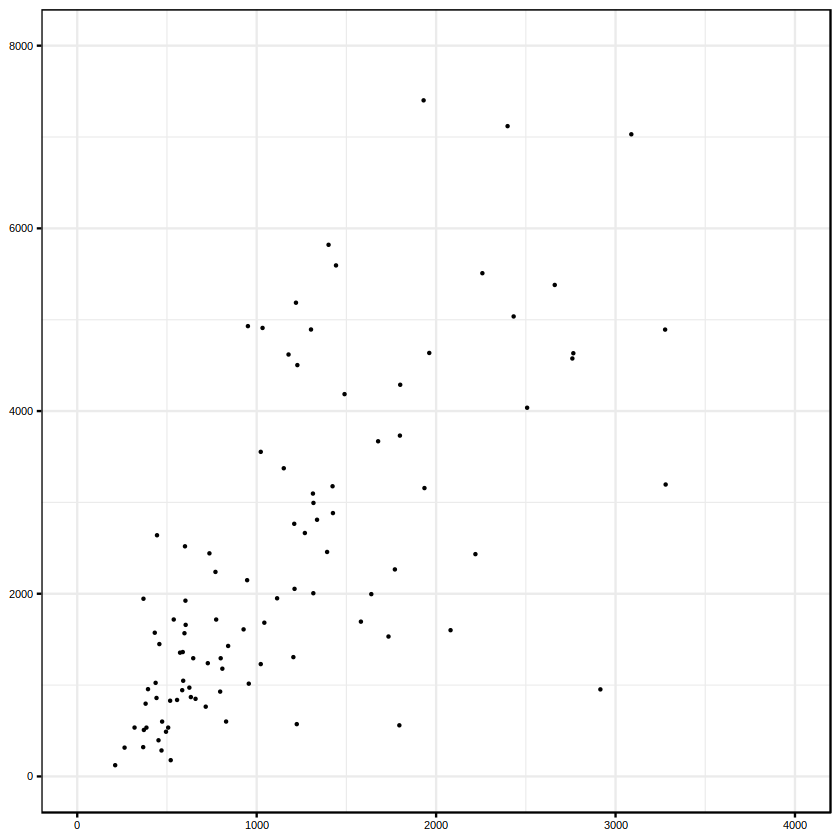

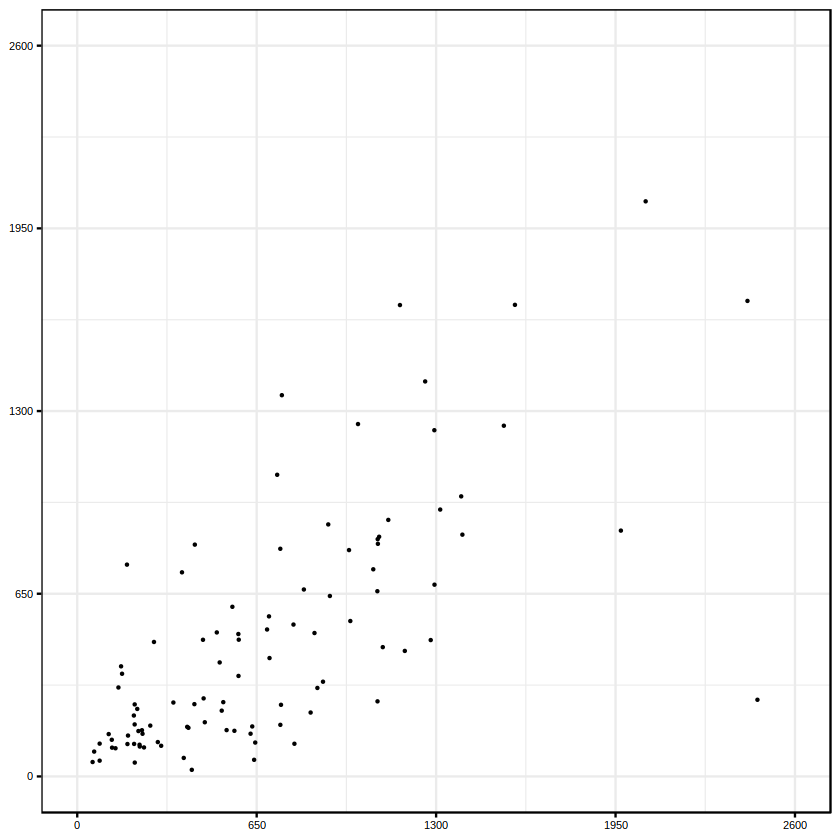

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)

# keepers: BNIP3L, HEMGN


HEIGHT = 1.5
WIDTH = 1.56

#--------------------------------------

gene_name <- "BNIP3L"

ensmbl_id <- gene_conv(gene_name,annotation)
gene_df <- data.frame(cf = cf_ftcounts[,ensmbl_id], 
                       wb = wb_ftcounts[,ensmbl_id]) 
gene_df %>%
    ggplot(aes(x=cf,y=wb))+
    geom_point(size =.2)+
#     annotate(geom="text",label=gene_name,x=-Inf,y=Inf,hjust=-.1,vjust=1.25, size = 4,color="blue")+
    labs(x= "Cell-Free RNA expression (CPM)", y = "Whole Blood RNA expression (CPM)")+
    theme_prevail()+
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          plot.title = element_text(hjust = 0.5),
            text = element_text(size = 8))+ 
    coord_cartesian(xlim = c(0,4000),ylim = c(0,8000)) + 
    scale_y_continuous(breaks = c(0,2000,4000,6000,8000)) +
    scale_x_continuous(breaks = c(0,1000,2000,3000,4000)) 

ggsave(paste0("./plots/SupPanelB_",gene_name,".pdf"),width = 1.5, height = 1.5)




#--------------------------------------

gene_name <- "HEMGN"

ensmbl_id <- gene_conv(gene_name,annotation)
gene_df <- data.frame(cf = cf_ftcounts[,ensmbl_id], 
                       wb = wb_ftcounts[,ensmbl_id]) 
gene_df %>%
    ggplot(aes(x=cf,y=wb))+
    geom_point(size =.2)+
#     annotate(geom="text",label=gene_name,x=-Inf,y=Inf,hjust=-.1,vjust=1.25, size = 4,color="blue")+
    labs(x= "Cell-Free RNA expression (CPM)", y = "Whole Blood RNA expression (CPM)")+
    theme_prevail()+
    theme(axis.title.x=element_blank(),
          axis.title.y=element_blank(),
          plot.title = element_text(hjust = 0.5),
            text = element_text(size = 8))+ 
    coord_cartesian(xlim = c(0,2600),ylim = c(0,2600)) + 
    scale_y_continuous(breaks = c(0,650,1300,1950,2600)) +
    scale_x_continuous(breaks = c(0,650,1300,1950,2600)) 

ggsave(paste0("./plots/SupPanelB_",gene_name,".pdf"),width = 1.5, height = 1.5)




---

In [8]:
tmp <- cor_df %>% filter(adj.p < 0.05) %>% filter(pearson < 0) %>% pull(gene_name)
length(tmp)
# cat(paste(tmp,collapse="\n"))

tmp <- cor_df %>% filter(adj.p < 0.05) %>% filter(pearson > 0) %>% pull(gene_name)
length(tmp)
# cat(paste(tmp,collapse="\n"))

cor_df %>% filter(adj.p > 0.05 | is.na(adj.p)) %>% nrow()

[1] 10

[1] 992

[1] 4769

In [9]:
992/1002

[1] 0.99002

In [12]:
cor_df$pearson <- ifelse(is.na(cor_df$pearson),0,cor_df$pearson)

order_rows <- cor_df %>% arrange(desc(pearson)) %>% pull(gene_name)


options(repr.plot.width = 16, repr.plot.height = 7)


HEIGHT = 1.37
WIDTH = 2.5

pdf(file=paste0("plots/SupPanelA_pearson-plot.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)


plt <- cor_df %>% 
    mutate(sig = ifelse(adj.p < 0.05,"1","0")) %>%
    mutate(gene_name = factor(gene_name, levels  = order_rows)) %>%
    ggplot(aes(x = gene_name,y = pearson))+
    geom_col(aes(fill=sig), alpha = 0.4)+
#     geom_smooth(aes(color=sig, group=1), method = "loess", span = 0.005, size = 2)+
    geom_line(aes(color=sig, group=1), size = .1, alpha = 1)+
   theme_prevail()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major = element_blank(),
          panel.grid.minor = element_blank())+ 
    coord_cartesian(ylim = c(-.325,0.75)) + 
    scale_y_continuous(breaks = c(-.25,0,0.25,0.5,0.75)) +
    scale_fill_manual(values = c("1"= "red", "0" = "grey"))+
    scale_color_manual(values = c("1"= "red", "0" = "grey"))
#     scale_fill_gradient2(low = "blue", high = "white", midpoint = 0.05, na.value = NA)

plt
dev.off()


png 
  2

---
## Simulation

In [13]:
sim_col <- read.delim("./simulation_output.cols.tsv")
sim_row <- read.delim("./simulation_output.rows.tsv")

sim_df <- data.frame(col_sig = sim_col$num_sig,
                     row_sig = sim_row$num_sig
                    )

sim_df_m <- melt(sim_df)

Warning message in melt(sim_df):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(sim_df). In the next version, this warning will become an error.”
No id variables; using all as measure variables



In [14]:
mean(sim_col$num_sig)
mean(sim_col$num_up)
mean(sim_col$num_down)

mean(sim_row$num_sig)
mean(sim_row$num_up)
mean(sim_row$num_down)

0.154/0.208

[1] 250.174

[1] 140.445

[1] 109.729

[1] 0.208

[1] 0.154

[1] 0.054

[1] 0.7403846

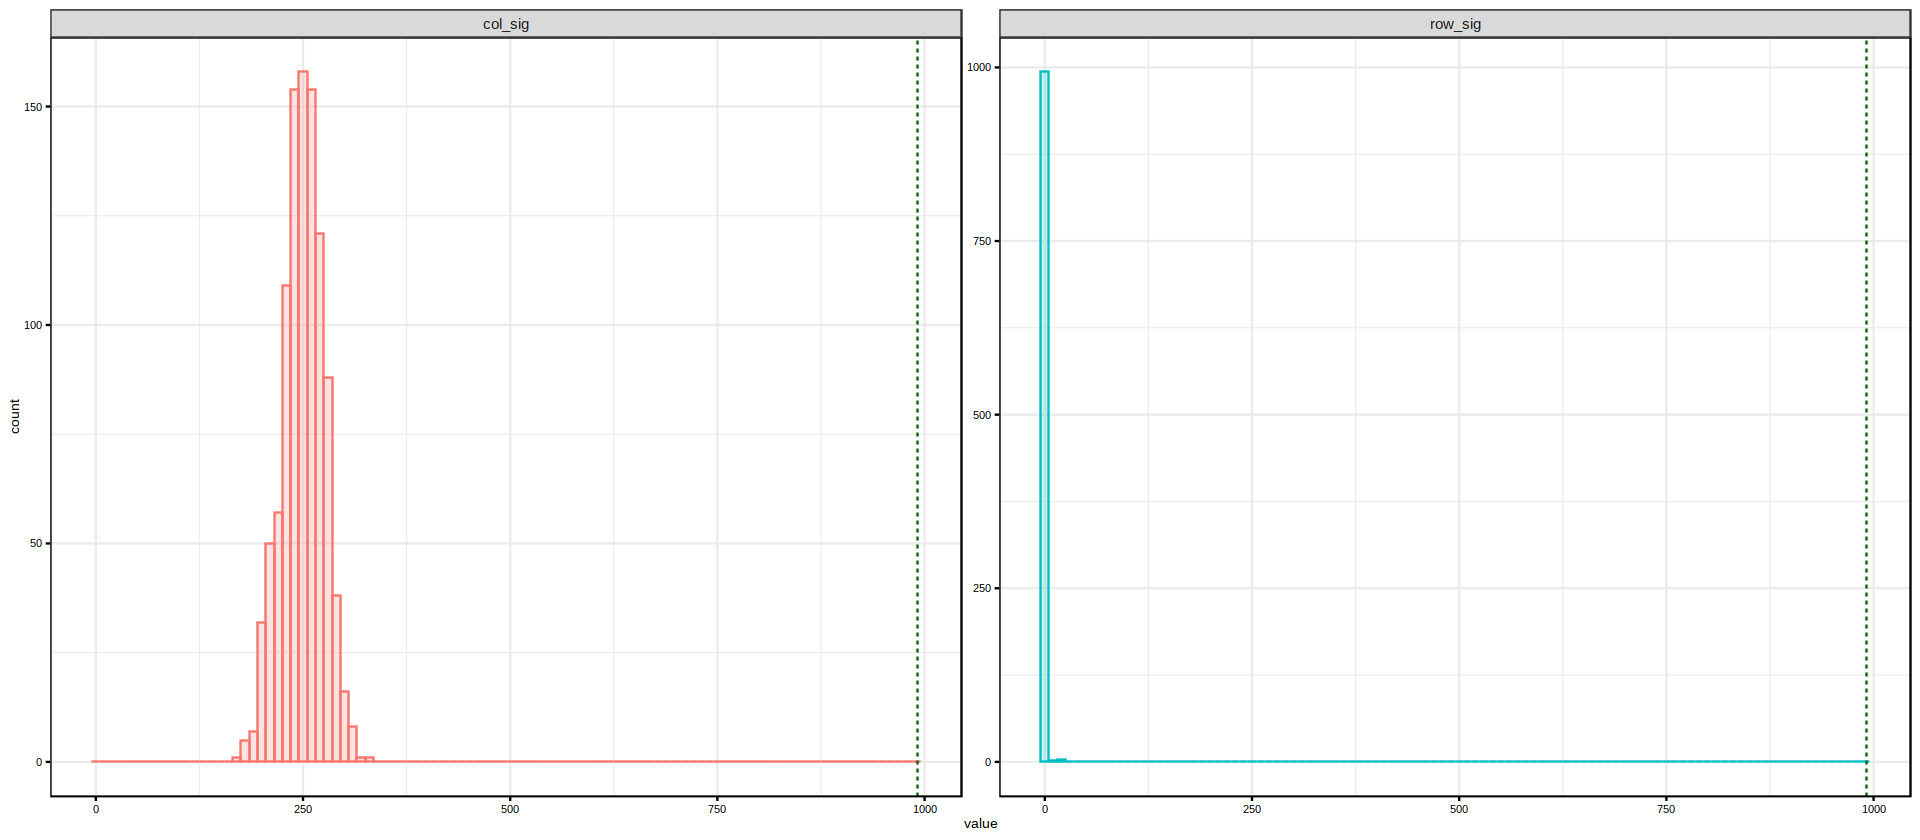

In [16]:
sim_df_m %>% 
    ggplot(aes(x=value,color=variable,fill=variable)) +
  geom_histogram(binwidth = 10, alpha = 0.2) + 
#     geom_density(alpha = 0.2) +
    geom_vline(xintercept=992, color = "dark green", lty=2) + 
    theme_prevail() + theme(legend.position = "none") + facet_wrap(~variable,scales = "free_y") #+ coord_cartesian(ylim = c(0,100)) 